In [1]:
# %load_ext lab_black

In [2]:
import torch
from torch import nn
from models import Generator, Discriminator
import utils
import numpy as np

In [3]:
ngpu = 1
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
G = Generator().to(device)
D = Discriminator().to(device)

if (device.type == "cuda") and (ngpu > 1):
    from sync_batchnorm import convert_model, DataParallelWithCallback

    G = convert_model(G)
    G = DataParallelWithCallback(G, list(range(ngpu)))
    D = nn.DataParallel(D, list(range(ngpu)))
G.apply(utils.weight_init)
D.apply(utils.weight_init)

cuda


Discriminator(
  (res_d0): ResBlock_DOWN(
    (sn_conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (sn_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU()
    (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (sn_conv_sc): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (res_d1): ResBlock_DOWN(
    (sn_conv0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (sn_conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU()
    (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (sn_conv_sc): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (attn_d): SelfAttention(
    (theta): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (phi): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (g): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (o): Conv2d(64, 128, kerne

In [4]:
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torchvision.transforms as transforms

In [5]:
class MyDataset(Dataset):
    def __init__(self, path, transforms=None):
        super(MyDataset, self).__init__()
        self.path = path
        self.transforms = transforms

    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        img = Image.open(self.path[idx]).convert("RGB")

        if self.transforms is not None:
            transformed_data = self.transforms(img)
        return transformed_data

In [6]:
from glob import glob

dataroot = glob(
    "/home/b20saito/WORK/DATASETS/anime-face-dataset/anime-face-dataset_4x/*.png"
)
batch_size = 64
dim_z = 128
num_epochs = 1

In [7]:
len(dataroot)

19314

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
datasets = MyDataset(dataroot, transforms=transform)

dataloader = DataLoader(datasets, batch_size=batch_size, shuffle=True)

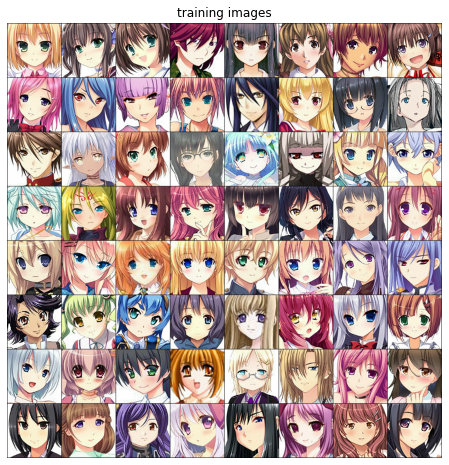

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

real_batch = next(iter(dataloader))
# print(real_batch)
# print(real_batch.shape)
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("training images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch.to(device), nrow=8, padding=2, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

In [10]:
fixed_noise = nn.init.normal_(torch.randn(batch_size, dim_z), mean=0, std=1.0)

In [11]:
# Hinge Loss
def loss_hinge_dis(dis_fake, dis_real):
    loss_real = torch.mean(F.relu(1.0 - dis_real))
    loss_fake = torch.mean(F.relu(1.0 + dis_fake))
    return loss_real, loss_fake


def loss_hinge_gen(dis_fake):
    loss_fake = -torch.mean(dis)

In [12]:
opt_G = optim.Adam(G.parameters(), lr=5e-5, betas=(0.0, 0.999), eps=1e-8)
opt_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.0, 0.999), eps=1e-8)

In [13]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Staring Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        print(i,data.shape)
        if data.size()[0] != batch_size:
            break
        #####################
        # Discriminatorの学習#
        #####################

        # 1.本物を本物と識別させる(真陽性の最大化=偽陰性の最小化)

        D.zero_grad()
        
        real = data.to(device)
        # 本物を識別させる
        dis_real = D(real)
        # 2.偽物を偽物と識別させる(真陰性の最大化=偽陽性の最小化)
       
        # ノイズから画像を生成する
        noise = nn.init.normal_(torch.randn(batch_size, dim_z), mean=0, std=1.0)
        fake = G(noise,noise)
        # 偽物を識別させる
        dis_fake = D(fake.detach())
        
        # ラベルとの損失を計算
        errD = loss_hinge_dis(dis_real, dis_fake)
        # 誤差逆伝播させる
        errD.backward()
        opt_D.step()

        ##################
        # Generatorの学習 #
        ##################

        # 偽物を本物と識別させる(偽陽性を最大化させる)
        G.zero_grad()
        # discriminatorで作った、fakeを使って偽物を識別させる
        gen_fake = D(fake)
        # ラベルとの損失を計算する
        errG = loss_hinge_gen(gen_fake)
        # 誤差逆伝播させる
        errG.backward()
        opt_G.step()

        # 学習状況を表示
        if i % 50 == 0:
            print(
                f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLossD: {errD.item():.4f}\tLossG: {errG.item():.4f}"
            )

        # あとでlossの図を表示するために保存
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        # Generatorの出力を定期的に見るやつ
        if (iters % 500 == 0) or (
            (epoch == num_epochs - 1) and (i == len(dataloader) - 1)
        ):
            with torch.no_grad():
                fake = G(fixed_noise,fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1

Staring Training Loop...
0 torch.Size([64, 3, 256, 256])
x torch.Size([64, 3, 256, 256])


RuntimeError: Given groups=1, weight of size 16 128 1 1, expected input[64, 512, 8, 8] to have 128 channels, but got 512 channels instead